In [267]:
import matplotlib.pyplot as plt
import random
import numpy as np
import pandas as pd
from matplotlib.ticker import LogFormatter 
from scipy.optimize import curve_fit
from pathlib import Path
import matplotlib.colors

from scipy.special import logsumexp

Для задачи про кривой кубок (стр 54):

In [268]:
# 0 - симметричный кубик
# 1 - кривой кубик

#матрица переходов между скрытыми состояниями:
A =  np.array([[0.95, 0.05], [0.1, 0.9]])
#A =  np.array([[0.5, 0.5], [0.8, 0.2]])

m = A.shape[0] #число скрытых состояний

n = 6 #Вариантов открытых состояний 

#Матрица эмиссий - открытые состояния из скрытых:
B = np.ones((m, n))
B[0, :] = B[0, :]/6
B[1, :] = B[1, :]/10
B[1, 5] = 0.5


#Начальное распределение состояний:
p = np.ones(m)/m
#p = np.array([1, 0])

In [269]:
def generate_sample(A, B, p0, L=2500):
    n = B.shape[1]
    m = A.shape[0]
    hidden_seq = np.zeros(L, dtype = int)
    open_seq = np.zeros(L, dtype = int)
    
    hidden_seq[0] = np.random.choice(m, p =p0)
    
    open_seq[0] = np.random.choice(n, p =B[hidden_seq[0]])
    for i in range(1, L):
        hidden_seq[i] = np.random.choice(m, p = A[hidden_seq[i-1]])
     
        open_seq[i] =  np.random.choice(n, p =B[hidden_seq[i]])
    
    return hidden_seq, open_seq

In [270]:
hidden_seq, open_seq = generate_sample(A, B, p)
initvalue = hidden_seq[0]
 

In [274]:
def Viterbi(A, B, p0, open_seq):
    
    L = len(open_seq)   
    m = A.shape[0]
    v = np.zeros((m, L))
    ptr = np.zeros((L, m)) #
    
    #Вроде мы знаем начальное распределение типов кубика, а не идет от определенного состояния 
    #v[:, 0] = np.log(p0) + np.log(B[:, open_seq[0]]) 
    #v[initvalue, 0] =  p0#1#np.log(np.multiply(p0, B[:, open_seq[0]]))
    v[:, 0] =  p0
    for i in range(1, L):
        #вероятность эмиссионная + переход
        v[:,i] = np.log(B[:, open_seq[i]]) + np.max(v[:,i-1].T + np.log(A.T), axis = 1) #check A 
        ptr[i, :] = np.argmax(v[:,i-1].T + np.log(A.T), axis = 1) #check axis 
  
    hidden_seq = np.zeros(L, dtype=int)
    hidden_seq[-1] = np.argmax(v[:, -1])
    for i in range(L - 1, 0, -1):
        hidden_seq[i - 1] = ptr[i, hidden_seq[i]]
    
    return hidden_seq

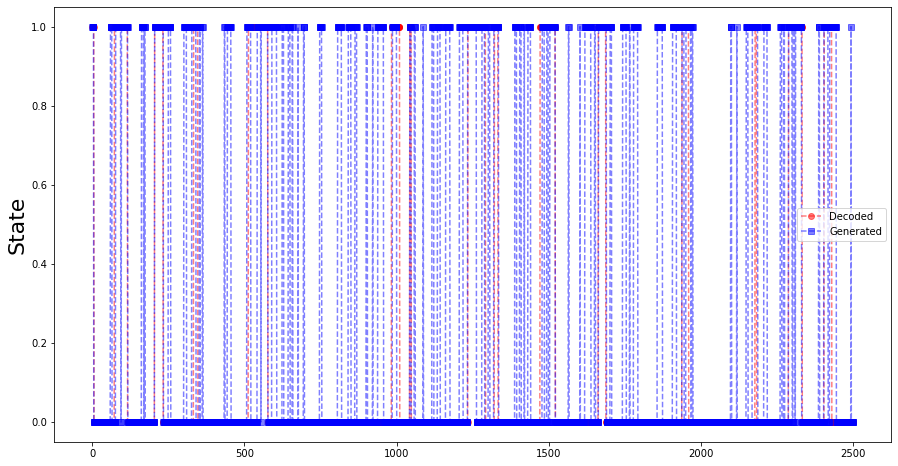

In [275]:
#A =  np.array([[0.8, 0.2], [0.1, 0.9]])
decoded = Viterbi(A, B, p, open_seq)
     
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
 
plt.plot(decoded, "o--", alpha = 0.5, c="r", label =  "Decoded")
plt.plot(hidden_seq, "s--", alpha = 0.5, c = "b", label = "Generated")

plt.ylabel(r"State", fontsize=22)

plt.legend()

In [276]:
def forward(A, B, p0, open_seq):
    m = A.shape[0]
    T = len(open_seq)
    f = np.zeros((T + 1, m))
    #f[0, initvalue] = 1#np.log(p0) + np.log(B[:, open_seq[0]])
    #f[0,  open_seq[0] ] = 1
    f[0, :] = p0
    log_px = 0.
    for t in range(1, T + 1):
        f[t] = B[:,  open_seq[t - 1]] * np.dot(f[t - 1], A)
        pt = f[t].sum()
        #print(f[t], pt)
        f[t] = f[t]/pt
        log_px += np.log(pt)
        #print(log_px)
    return f, log_px
 

In [299]:
def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((T + 1, m))
    b[T, :] = 1
    log_px = 0.
    for t in range(T, 0, -1):
        b[t - 1] = np.dot(A, b[t] * B[:, open_seq[t - 1]])
        pt = b[t - 1].sum()
        b[t - 1]  = b[t - 1] / pt
        log_px += np.log(pt)
        #print(log_px)
    #log_px += np.log(b[0, initvalue])
    log_px += np.log(np.sum( b[0, :]*p0 ) )
    return b, log_px    

In [300]:
fdecoded, bdecoded

(-4409.844269859178, -4409.844269859175)

-4409.844269859178 -4410.200874608531


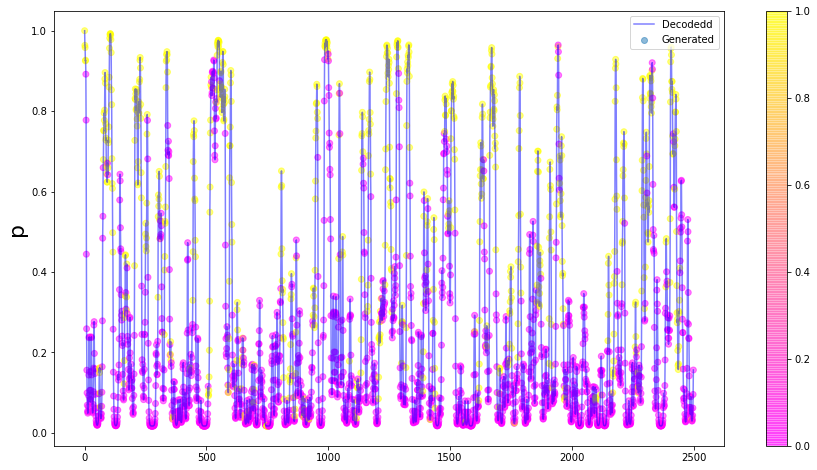

In [301]:
f, fdecoded = forward(A, B, p, open_seq)

b, bdecoded = backward(A, B, p, open_seq)
print(fdecoded, bdecoded)
       
fig = plt.figure(figsize=(15, 8))
ax = fig.add_subplot(111)
gamma = f[:-1, :] * b[:-1, :]
#gamma = (f*b)
#gamma = gamma.T
#print(gamma.shape, gamma[:,1].shape)
gamma /= np.sum(gamma, axis=1, keepdims=True)
plt.scatter(np.arange(len(hidden_seq)), gamma[:,1],  alpha = 0.5, c=hidden_seq, label =  "Generated", cmap = "spring")

plt.plot(np.arange(len(hidden_seq)),gamma [:,1], "-", alpha = 0.5, c = "b", label = "Decodedd")

#plt.xlabel(r' $ \% $', fontsize = 22)
plt.ylabel(r"p", fontsize=22)

plt.legend()

plt.colorbar()

In [252]:
def forward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    f = np.zeros((m, T))
    f[:, 0] = np.log(p0) + np.log(B[:,open_seq[0]])
    log_px = logsumexp(f[:, 0])  #np.sum(f[:, 0])#logsumexp(f[:, 0])   #logsumexp(f[:, 0])#0#np.sum(f[:, 0]) 
    print(log_px, "start")
    for i in range(1, T):
        for l in range(m):
            log1 = f[0, i - 1] + np.log(A[0, l])
            log2 = np.log(1 + np.exp(f[1, i - 1] + np.log(A[1, l]) - log1))
            log_sum = log1 + log2
            f[ l, i] = np.log(B[ l, open_seq[i]]) + log_sum
            #if (i!=T-1):
        log_px += logsumexp(f[:, i])
            #log_px += logsumexp(f[l, i])
    #log_px -= np.sum(f[:, -1])
    f_probs = f[0, -1] + np.log(1 + np.exp(f[1, -1] - f[0, -1]))
    #print(log_px, "f-")
    #print(f_probs)
    log_px += np.sum(f_probs)
    #log_px += logsumexp(f_probs)#f_probs#logsumexp(f_probs)
    #log_px += logsumexp(f[:, 0]) #f_probs #logsumexp(f[:, 0])
    print(log_px)
    return np.exp(f), log_px  

def backward(A, B, p0, open_seq):
    T = len(open_seq)
    m = A.shape[0]
    b = np.zeros((m, T))
    b[:, -1] = 1
    log_px = logsumexp(b[:, -1])  #np.sum(b[:, -1])
    for i in range(T - 2, -1, -1):
        for k in range(m):
            log1 = b[0, i + 1] + np.log(A[k, 0]) + np.log(B[0, open_seq[i + 1]])
            log2 = np.log(1 + np.exp(b[1, i + 1] + np.log(A[k, 1]) + np.log(B[1, open_seq[i + 1]]) - log1))
            b[k, i] = log1 + log2
            #if (i!=0):
            #log_px += b[k, i]
            #log_px += logsumexp(b[k, i])
        log_px += logsumexp(b[:, i])
    log1 = b[0, 1] + np.log(p0[0]) + np.log(B[0, open_seq[1]])
    log2 = np.log(1 + np.exp(b[1, 1] + np.log(p0[1]) + np.log(B[1, open_seq[1]]) - log1))
    b_probs = log1 + log2
    #log_px += logsumexp(b_probs)
    #log_px -= np.sum(b[:, 0])
     
    #log_px -= logsumexp(b[:, -1])
    #log_px += np.sum(np.log(p0) + np.log(B[:, open_seq[0] ]))
    print(log_px, "b-")
    print(b_probs)
    #log_px -= np.sum(b_probs) #np.log(p0) + np.log(B[:,open_seq[0]])
    print(log_px)
    #np.sum(b_probs) #np.log(p0) + np.log(B[:,open_seq[0]])
    return np.exp(b), log_px